In [1]:
import numpy as np
from matplotlib import pyplot as plt
import json
import xarray as xr

import decoherence as dc

plt.style.use("seaborn-ticks")


/var/folders/k3/y60qc5dn2lsff_h2hgv2zlbc0000gn/T/ipykernel_95344/3349704112.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-ticks")


In [62]:
# Define constants
alpha = 1
SV0 = 7.9e-5  # white noise power based on datasheet, in uV^2/Hz
fc_100M = 100e6    # cutoff frequency in Hz
fc_32k = 32e3
AV = 1.3e-12 / 2  # 1/f noise power, V^2/Hz, measured noise is single-sided, hence divide by 2
SVz_100M = lambda omega: (SV0 * 1e-12 + AV / (omega / (2 * np.pi))) / (1 + (omega / (fc_100M * 2 * np.pi))**2)
SVx_100M = lambda omega: (SV0 * 1e-12 + AV / (omega / (2 * np.pi))) / (1 + (omega / (fc_100M * 2 * np.pi))**2)
#SVx_100M = lambda omega: 0
SVz_32k = lambda omega: (SV0 * 1e-12 + AV / (omega / (2 * np.pi))) / (1 + (omega / (fc_32k * 2 * np.pi))**2)
SVx_32k = lambda omega: (SV0 * 1e-12 + AV / (omega / (2 * np.pi))) / (1 + (omega / (fc_32k * 2 * np.pi))**2)
#SVx_32k = lambda omega: 0

mutual_matrix = np.array([[-0.848434, -0.0090408], [-0.00513571, 1.07659]]) #Phi_0/V

S_Phi_z_100M = lambda omega: SVz_100M(omega) * (mutual_matrix[0, 0]) ** 2
S_Phi_z_32k = lambda omega: SVz_32k(omega) * (mutual_matrix[0, 0]) ** 2


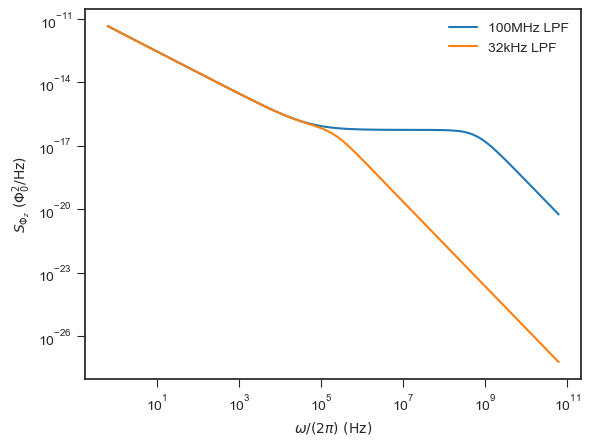

In [63]:
omegas = 2 * np.pi * np.geomspace(0.1, 1e10, 101)
S_Phi_zs_100M = S_Phi_z_100M(omegas)
S_Phi_zs_32k = S_Phi_z_32k(omegas)
plt.plot(omegas, S_Phi_zs_100M, label="100MHz LPF")
plt.plot(omegas, S_Phi_zs_32k, label="32kHz LPF")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\omega/(2\pi)~(\mathrm{Hz})$")
plt.ylabel(r"$S_{\Phi_z}~(\Phi_0^2/\mathrm{Hz})$")
plt.legend()

In [64]:
def dephasing_times(
    domega_dfz_0011,
    domega_dfx_0011,
    Svz, Svx, mutual_matrix
):
    S_fz = lambda omega: mutual_matrix[0, 0] ** 2 * Svz(omega) + mutual_matrix[0, 1] ** 2 * Svx(omega)
    S_fx = lambda omega: mutual_matrix[1, 1] ** 2 * Svx(omega) + mutual_matrix[1, 0] ** 2 * Svz(omega)
    c_fz_fx = lambda omega : (
        mutual_matrix[0][0] * mutual_matrix[1][0] * Svz(omega) + 
        mutual_matrix[0][1] * mutual_matrix[1][1] * Svx(omega)
    )
    S_omega_01 = lambda omega: (
        domega_dfz_0011 ** 2 * S_fz(omega)
        + domega_dfx_0011 ** 2 * S_fx(omega)
        + 2 * (domega_dfz_0011 * domega_dfx_0011) * c_fz_fx(omega)
    )
    return dc.t_phi_arb_psd(S_omega_01)

In [65]:
with open(f"DeviceParameters/0.32sensitivitySweep.json", "r") as f:
    fz_sensitivity_data = json.load(f)
fz_da = xr.Dataset(
    data_vars = {
            key: ("fz", [d["Average"][key] for d in fz_sensitivity_data["Data"]]) for key in ["dHdfz0011", "dHdfx0011"]
    },
    coords = {"fz": fz_sensitivity_data["SweepSpecifiers"][0][1]}
)
fz_da["T_phi_Ramsey_100M"] = xr.DataArray(
    [
        dephasing_times(dHdfz * 1e9 * 2 * np.pi, dHdfx * 1e9 * 2 * np.pi, SVz_100M, SVx_100M, mutual_matrix)["T2Ramsey"] for dHdfz, dHdfx in zip(fz_da["dHdfz0011"].data, fz_da["dHdfx0011"].data)
        ],
    coords={"fz": fz_da["fz"]}
)
fz_da["T_phi_Ramsey_32k"] = xr.DataArray(
    [
        dephasing_times(dHdfz * 1e9 * 2 * np.pi, dHdfx * 1e9 * 2 * np.pi, SVz_32k, SVx_32k, mutual_matrix)["T2Ramsey"] for dHdfz, dHdfx in zip(fz_da["dHdfz0011"].data, fz_da["dHdfx0011"].data)
        ],
    coords={"fz": fz_da["fz"]}
)


/Users/xidai/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofWaterloo/SQDQEO - Papers/AnnealingCSFQDecoherence/AnalysisData/20240505_RedoCoherenceFitPython/decoherence.py:429: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = integrate.quad(integrand, cutoff, np.inf)
/Users/xidai/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofWaterloo/SQDQEO - Papers/AnnealingCSFQDecoherence/AnalysisData/20240505_RedoCoherenceFitPython/decoherence.py:429: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = integrate.quad(integran

(0.0, 1.25e-06)

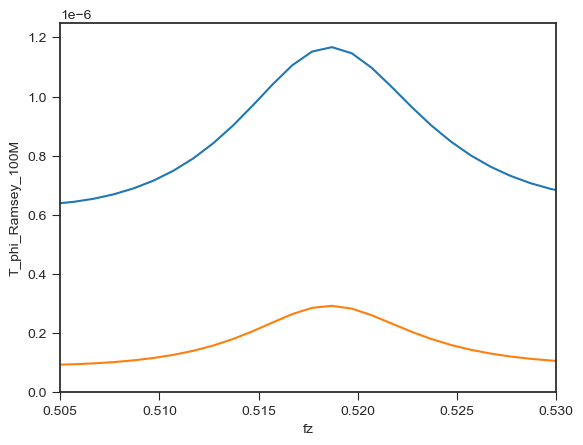

In [66]:
fz_da["T_phi_Ramsey_32k"].plot()
fz_da["T_phi_Ramsey_100M"].plot()
plt.xlim(0.505, 0.53)
plt.ylim(0, 1.25e-6)